In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


In [3]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non-null  float64
 13  WHEELS_OFF           5730032 non-null  float64
 14  SCHEDULED_TIME       5819073 non-null  float64
 15

In [4]:
# I remove Nans from columns where flights were cancelled (or diverted)
df.dropna(subset=['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 
                'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY'], inplace=True)
# I remove columns 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'
df.drop(['DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'], axis=1, inplace=True)
# I remove also 'YEAR' column - all flights were in 2015
df.drop(['YEAR'], axis=1, inplace=True)
# I remove columns with insufficient data
df.drop(["AIR_SYSTEM_DELAY","SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"], axis=1, inplace=True)

In [5]:
df.sample(10)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
352204,1,23,5,AA,1522,N3HLAA,SFO,ORD,2330,2323.0,...,534.0,6.0,528,540.0,12.0,NaN,NaN,NaN,NaN,NaN
1396489,3,31,2,DL,1902,N917DL,LGA,PBI,1445,1446.0,...,1739.0,4.0,1756,1743.0,-13.0,NaN,NaN,NaN,NaN,NaN
598924,2,9,1,WN,48,N353SW,BNA,HOU,1515,1525.0,...,1719.0,8.0,1730,1727.0,-3.0,NaN,NaN,NaN,NaN,NaN
3726232,8,19,3,EV,5100,N719EV,MOB,ATL,2008,1959.0,...,2205.0,9.0,2222,2214.0,-8.0,NaN,NaN,NaN,NaN,NaN
5504368,12,11,5,OO,2956,N906SW,PHX,YUM,1440,1447.0,...,1542.0,3.0,1539,1545.0,6.0,NaN,NaN,NaN,NaN,NaN
963033,3,5,4,UA,1407,N67815,LAX,IAH,45,39.0,...,536.0,5.0,555,541.0,-14.0,NaN,NaN,NaN,NaN,NaN
5406792,12,5,6,UA,210,N842UA,MEM,DEN,844,1004.0,...,1113.0,5.0,1025,1118.0,53.0,0.0,0.0,53.0,0.0,0.0
3496454,8,6,4,HA,115,N475HA,OGG,HNL,720,720.0,...,749.0,7.0,755,756.0,1.0,NaN,NaN,NaN,NaN,NaN
246040,1,16,5,B6,993,N834JB,BOS,DEN,1945,1954.0,...,2222.0,6.0,2230,2228.0,-2.0,NaN,NaN,NaN,NaN,NaN
4767280,10,25,7,OO,6450,N976SW,12892,14570,845,838.0,...,1006.0,5.0,1018,1011.0,-7.0,NaN,NaN,NaN,NaN,NaN


In [6]:
# Each entry of the flights.csv file corresponds to a flight and we see that more than 5'800'000 flights have been recorded in 2015. These flights are described according to 31 variables. A description of these variables can be found here and I briefly recall the meaning of the variables that will be used in this notebook:

# YEAR, MONTH, DAY, DAY_OF_WEEK: dates of the flight
# AIRLINE: An identification number assigned by US DOT to identify a unique airline
# ORIGIN_AIRPORT and DESTINATION_AIRPORT: code attributed by IATA to identify the airports
# SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL : scheduled times of take-off and landing
# DEPARTURE_TIME and ARRIVAL_TIME: real times at which take-off and landing took place
# DEPARTURE_DELAY and ARRIVAL_DELAY: difference (in minutes) between planned and real times
# DISTANCE: distance (in miles)
# An additional file of this dataset, the airports.csv file, gives a more exhaustive description of the airports:

In [7]:
airports=pd.read_csv('airports.csv')
airports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [8]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [9]:
airports[airports['LATITUDE'].isna()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


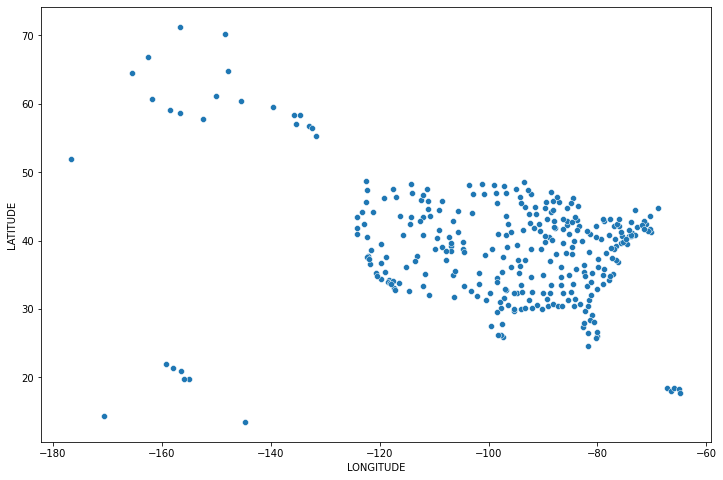

In [10]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=airports)
plt.show()

In [11]:
airports[airports['STATE'] == 'NY']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
14,ALB,Albany International Airport,Albany,NY,USA,42.74812,-73.80298
29,BGM,Greater Binghamton Airport,Binghamton,NY,USA,42.20848,-75.97961
49,BUF,Buffalo Niagara International Airport,Buffalo,NY,USA,42.94052,-78.73217
99,ELM,Elmira/Corning Regional Airport,Elmira,NY,USA,42.15991,-76.89144
144,HPN,Westchester County Airport,White Plains,NY,USA,41.06696,-73.70757
150,IAG,Niagara Falls International Airport,Niagara Falls,NY,USA,43.10726,-78.94538
160,ISP,Long Island MacArthur Airport,Islip,NY,USA,40.79524,-73.10021
161,ITH,Ithaca Tompkins Regional Airport,Ithaca,NY,USA,42.49103,-76.45844
166,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
182,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261


In [12]:
# taking real world data for Plattsburgh International Airport:
airports.loc[234,'LATITUDE'] = 44.3903
airports.loc[234,'LONGITUDE']= -73.2805

In [13]:
airports[airports['AIRPORT'] == 'Plattsburgh International Airport']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,44.3903,-73.2805


In [14]:
airports[airports['STATE'] == 'FL']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
80,DAB,Daytona Beach International Airport,Daytona Beach,FL,USA,29.17992,-81.05806
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
107,EYW,Key West International Airport,Key West,FL,USA,24.55611,-81.75956
114,FLL,Fort Lauderdale-Hollywood International Airport,Ft. Lauderdale,FL,USA,26.07258,-80.15275
125,GNV,Gainesville Regional Airport,Gainesville,FL,USA,29.69006,-82.27178
165,JAX,Jacksonville International Airport,Jacksonville,FL,USA,30.49406,-81.68786
193,MCO,Orlando International Airport,Orlando,FL,USA,28.42889,-81.31603
203,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056
206,MLB,Melbourne International Airport,Melbourne,FL,USA,28.10275,-80.64581
235,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559


In [15]:
# taking real world data also for other two Airports:
airports.loc[96,'LATITUDE'] = 30.2130
airports.loc[96,'LONGITUDE']= -85.4744
airports.loc[313,'LATITUDE'] = 29.57333
airports.loc[313,'LONGITUDE']= -81.2023

In [16]:
# In airports.csv we have airports only from one country - USA
airports['COUNTRY'].value_counts()

USA    322
Name: COUNTRY, dtype: int64

In [17]:
airlines_names=pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [18]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()
abbr_companies

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'US': 'US Airways Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'VX': 'Virgin America'}

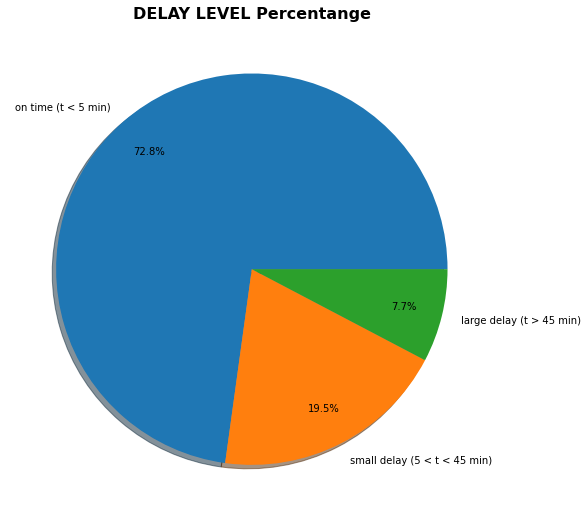

In [28]:
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)

# 
delay_level = dict(df.groupby('DELAY_LEVEL')['DELAY_LEVEL'].count())
labels = ['on time (t < 5 min)', 'small delay (5 < t < 45 min)', 'large delay (t > 45 min)']
values = delay_level.values()
plt.figure(figsize=(9,9))
plt.pie(data=df, x=values, labels= labels, autopct = '%1.1f%%', pctdistance=0.8, shadow=True)
plt.title('DELAY LEVEL Percentange', fontsize=16, weight = 'bold')
plt.show()

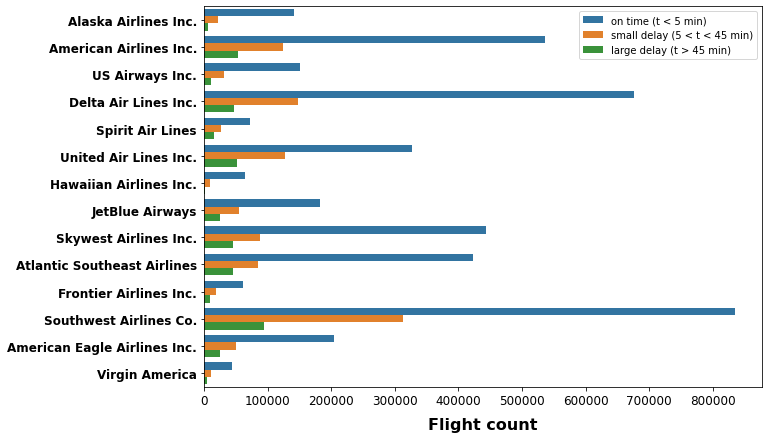

In [19]:
# Create bar chart: Flight count delays vs airlines companies
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)

# Replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

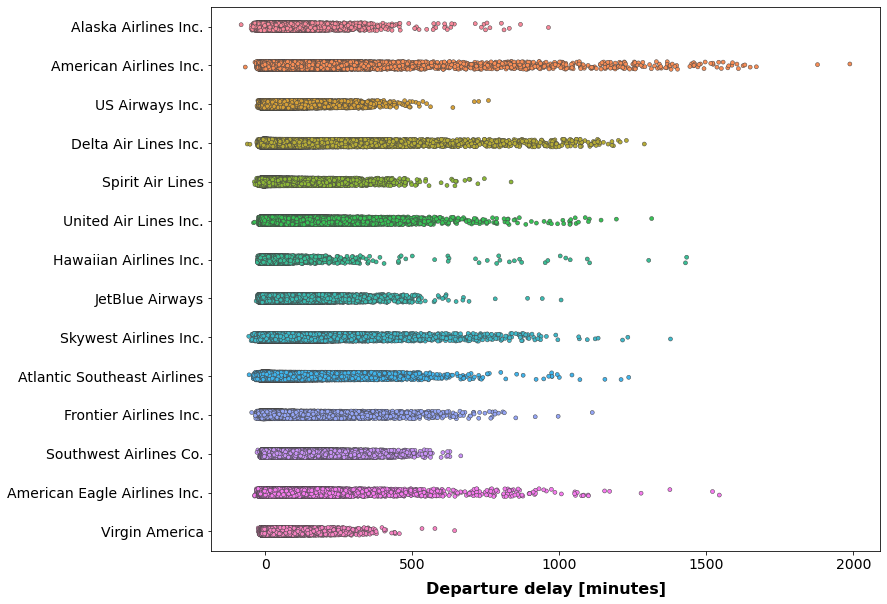

In [33]:
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)

plt.figure(figsize=(12,10))
ax = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, 
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.xlabel('Departure delay [minutes]', fontsize=16, weight = 'bold', labelpad=10)
ax.yaxis.label.set_visible(False)
plt.show()

In [34]:
# In dataframe we have two types of airports codes: 3-letter code (like in airports.csv) and 5-digit code
df['ORIGIN_AIRPORT'].value_counts()

ATL      343506
ORD      276554
DFW      232647
DEN      193402
LAX      192003
          ...  
13541        11
10165         9
14222         9
13502         6
11503         4
Name: ORIGIN_AIRPORT, Length: 628, dtype: int64

In [35]:
# checking airports marked in 5-digit code
df_dig = df[df['ORIGIN_AIRPORT'] < '99999']
df_dig

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAY_LEVEL
4385712,10,1,4,AA,1230,N3DBAA,14747,11298,5,15.0,...,4.0,602,543.0,-19.0,NaN,NaN,NaN,NaN,NaN,1
4385713,10,1,4,DL,1805,N696DL,14771,13487,5,16.0,...,7.0,538,528.0,-10.0,NaN,NaN,NaN,NaN,NaN,1
4385714,10,1,4,NK,612,N602NK,12889,13487,5,2400.0,...,4.0,502,448.0,-14.0,NaN,NaN,NaN,NaN,NaN,0
4385715,10,1,4,AA,260,N3GNAA,12892,13303,10,7.0,...,7.0,806,813.0,7.0,NaN,NaN,NaN,NaN,NaN,0
4385716,10,1,4,AA,1982,N914UY,14771,11057,10,8.0,...,13.0,801,750.0,-11.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871872,10,31,6,B6,98,N715JB,11292,12478,2359,14.0,...,8.0,427,427.0,0.0,NaN,NaN,NaN,NaN,NaN,1
4871873,10,31,6,B6,839,N834JB,12478,10732,2359,2358.0,...,4.0,339,322.0,-17.0,NaN,NaN,NaN,NaN,NaN,0
4871874,10,31,6,B6,1503,N907JB,12478,14843,2359,132.0,...,7.0,342,502.0,80.0,0.0,0.0,80.0,0.0,0.0,2
4871875,10,31,6,UA,1696,N68836,14747,12266,2359,2353.0,...,8.0,504,442.0,-22.0,NaN,NaN,NaN,NaN,NaN,0


In [36]:
df_dig['FLIGHT_NUMBER'].value_counts()

612     388
357     384
340     366
683     352
188     350
       ... 
6276      1
4157      1
4153      1
6519      1
5826      1
Name: FLIGHT_NUMBER, Length: 5973, dtype: int64

In [37]:
(df_dig['FLIGHT_NUMBER'].value_counts() == 1).sum()

46

In [38]:
df_dig['ORIGIN_AIRPORT'].value_counts()

10397    32509
13930    27566
11298    20586
11292    18077
12892    17628
         ...  
13541       11
10165        9
14222        9
13502        6
11503        4
Name: ORIGIN_AIRPORT, Length: 306, dtype: int64

In [39]:
df_dig['DESTINATION_AIRPORT'].value_counts()

10397    32546
13930    27506
11298    20461
11292    18065
12892    17647
         ...  
10165        9
14222        9
13502        7
11503        3
10666        1
Name: DESTINATION_AIRPORT, Length: 307, dtype: int64

In [40]:
# checking airports marked in 3-letter code
df_air = df[df['ORIGIN_AIRPORT'] > 'AAA']
df_air

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAY_LEVEL
0,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,...,4.0,430,408.0,-22.0,NaN,NaN,NaN,NaN,NaN,0
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,...,4.0,750,741.0,-9.0,NaN,NaN,NaN,NaN,NaN,0
2,1,1,4,US,840,N171US,SFO,CLT,20,18.0,...,11.0,806,811.0,5.0,NaN,NaN,NaN,NaN,NaN,0
3,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,...,8.0,805,756.0,-9.0,NaN,NaN,NaN,NaN,NaN,0
4,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,...,5.0,320,259.0,-21.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,12,31,4,B6,688,N657JB,LAX,BOS,2359,2355.0,...,4.0,819,753.0,-26.0,NaN,NaN,NaN,NaN,NaN,0
5819075,12,31,4,B6,745,N828JB,JFK,PSE,2359,2355.0,...,3.0,446,430.0,-16.0,NaN,NaN,NaN,NaN,NaN,0
5819076,12,31,4,B6,1503,N913JB,JFK,SJU,2359,2350.0,...,8.0,440,432.0,-8.0,NaN,NaN,NaN,NaN,NaN,0
5819077,12,31,4,B6,333,N527JB,MCO,SJU,2359,2353.0,...,3.0,340,330.0,-10.0,NaN,NaN,NaN,NaN,NaN,0


In [41]:
df_air['ORIGIN_AIRPORT'].value_counts()

ATL    343506
ORD    276554
DFW    232647
DEN    193402
LAX    192003
        ...  
STC        77
DLG        77
GST        76
AKN        63
ITH        30
Name: ORIGIN_AIRPORT, Length: 322, dtype: int64

In [42]:
df_air['DESTINATION_AIRPORT'].value_counts()

ATL    343076
ORD    275864
DFW    231764
DEN    193033
LAX    192136
        ...  
STC        77
DLG        77
GST        74
AKN        63
ITH        31
Name: DESTINATION_AIRPORT, Length: 322, dtype: int64

In [43]:
df_dig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482878 entries, 4385712 to 4871876
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   MONTH                482878 non-null  int64  
 1   DAY                  482878 non-null  int64  
 2   DAY_OF_WEEK          482878 non-null  int64  
 3   AIRLINE              482878 non-null  object 
 4   FLIGHT_NUMBER        482878 non-null  int64  
 5   TAIL_NUMBER          482878 non-null  object 
 6   ORIGIN_AIRPORT       482878 non-null  object 
 7   DESTINATION_AIRPORT  482878 non-null  object 
 8   SCHEDULED_DEPARTURE  482878 non-null  int64  
 9   DEPARTURE_TIME       482878 non-null  float64
 10  DEPARTURE_DELAY      482878 non-null  float64
 11  TAXI_OUT             482878 non-null  float64
 12  WHEELS_OFF           482878 non-null  float64
 13  SCHEDULED_TIME       482878 non-null  float64
 14  ELAPSED_TIME         482878 non-null  float64
 15  AIR_TIME  

In [44]:
df_air.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5231130 entries, 0 to 5819078
Data columns (total 28 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   MONTH                5231130 non-null  int64  
 1   DAY                  5231130 non-null  int64  
 2   DAY_OF_WEEK          5231130 non-null  int64  
 3   AIRLINE              5231130 non-null  object 
 4   FLIGHT_NUMBER        5231130 non-null  int64  
 5   TAIL_NUMBER          5231130 non-null  object 
 6   ORIGIN_AIRPORT       5231130 non-null  object 
 7   DESTINATION_AIRPORT  5231130 non-null  object 
 8   SCHEDULED_DEPARTURE  5231130 non-null  int64  
 9   DEPARTURE_TIME       5231130 non-null  float64
 10  DEPARTURE_DELAY      5231130 non-null  float64
 11  TAXI_OUT             5231130 non-null  float64
 12  WHEELS_OFF           5231130 non-null  float64
 13  SCHEDULED_TIME       5231130 non-null  float64
 14  ELAPSED_TIME         5231130 non-null  float64
 15

In [45]:
df['AIRLINE'].value_counts()

WN    1242403
DL     870275
AA     712935
OO     576814
EV     554752
UA     507762
MQ     278791
B6     262042
US     194223
AS     171439
NK     115193
F9      90090
HA      76041
VX      61248
Name: AIRLINE, dtype: int64

In [46]:
df['TAIL_NUMBER'].value_counts()

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N840MH       1
N175UA       1
N180UA       1
N7LEAA       1
N860NW       1
Name: TAIL_NUMBER, Length: 4896, dtype: int64

In [47]:
df[(df['TAIL_NUMBER'] == 'N961SW') & (df['FLIGHT_NUMBER'] == 5337)]

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAY_LEVEL
95199,1,7,3,OO,5337,N961SW,MAF,DEN,615,607.0,...,5.0,709,718.0,9.0,NaN,NaN,NaN,NaN,NaN,0
395973,1,27,2,OO,5337,N961SW,MAF,DEN,615,604.0,...,8.0,709,650.0,-19.0,NaN,NaN,NaN,NaN,NaN,0
1630405,4,15,3,OO,5337,N961SW,MAF,DEN,615,604.0,...,9.0,708,703.0,-5.0,NaN,NaN,NaN,NaN,NaN,0
5571402,12,16,3,OO,5337,N961SW,MAF,DEN,619,612.0,...,11.0,714,723.0,9.0,NaN,NaN,NaN,NaN,NaN,0


In [48]:
(df['FLIGHT_NUMBER'].value_counts() == 1).sum()

35

In [49]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DELAY_LEVEL'],
      dtype='object')

In [21]:
# deleting columns 'FLIGHT_NUMBER', 'TAIL_NUMBER' - 
df.drop(['FLIGHT_NUMBER', 'TAIL_NUMBER'], axis=1, inplace=True)

In [23]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5714008 entries, 0 to 5819078
Data columns (total 24 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5714008 non-null  int64  
 1   MONTH                5714008 non-null  int64  
 2   DAY                  5714008 non-null  int64  
 3   DAY_OF_WEEK          5714008 non-null  int64  
 4   AIRLINE              5714008 non-null  object 
 5   ORIGIN_AIRPORT       5714008 non-null  object 
 6   DESTINATION_AIRPORT  5714008 non-null  object 
 7   SCHEDULED_DEPARTURE  5714008 non-null  int64  
 8   DEPARTURE_TIME       5714008 non-null  float64
 9   DEPARTURE_DELAY      5714008 non-null  float64
 10  TAXI_OUT             5714008 non-null  float64
 11  WHEELS_OFF           5714008 non-null  float64
 12  SCHEDULED_TIME       5714008 non-null  float64
 13  ELAPSED_TIME         5714008 non-null  float64
 14  AIR_TIME             5714008 non-null  float64
 15

In [28]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5714008 entries, 0 to 5819078
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   MONTH                5714008 non-null  int64  
 1   DAY                  5714008 non-null  int64  
 2   DAY_OF_WEEK          5714008 non-null  int64  
 3   AIRLINE              5714008 non-null  object 
 4   ORIGIN_AIRPORT       5714008 non-null  object 
 5   DESTINATION_AIRPORT  5714008 non-null  object 
 6   SCHEDULED_DEPARTURE  5714008 non-null  int64  
 7   DEPARTURE_TIME       5714008 non-null  float64
 8   DEPARTURE_DELAY      5714008 non-null  float64
 9   TAXI_OUT             5714008 non-null  float64
 10  WHEELS_OFF           5714008 non-null  float64
 11  SCHEDULED_TIME       5714008 non-null  float64
 12  ELAPSED_TIME         5714008 non-null  float64
 13  AIR_TIME             5714008 non-null  float64
 14  DISTANCE             5714008 non-null  int64  
 15

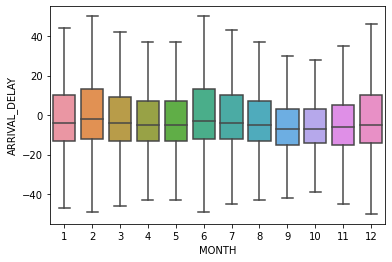

In [29]:
sns.boxplot(x='MONTH', y='ARRIVAL_DELAY', data=df, showfliers=False)
plt.show()

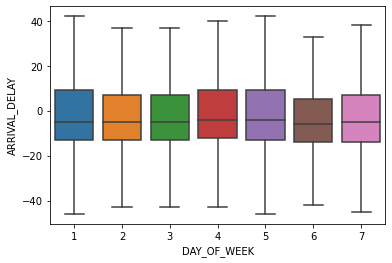

In [30]:
sns.boxplot(x='DAY_OF_WEEK', y='ARRIVAL_DELAY', data=df, showfliers=False)
plt.show()

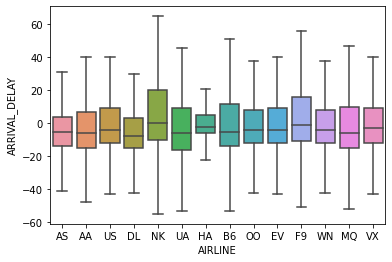

In [31]:
sns.boxplot(x='AIRLINE', y='ARRIVAL_DELAY', data=df, showfliers=False)
plt.show()

In [32]:
df.sample(10)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
5782792,12,29,2,EV,IAH,LRD,1445,1437.0,-8.0,10.0,1447.0,76.0,72.0,60.0,301,1547.0,2.0,1601,1549.0,-12.0
5576399,12,16,3,UA,ATL,EWR,1116,1125.0,9.0,13.0,1138.0,140.0,114.0,87.0,746,1305.0,14.0,1336,1319.0,-17.0
1739776,4,21,2,UA,MCO,LAX,1902,1853.0,-9.0,13.0,1906.0,323.0,334.0,308.0,2218,2114.0,13.0,2125,2127.0,2.0
3347356,7,28,2,DL,ATL,BHM,1120,1117.0,-3.0,15.0,1132.0,52.0,47.0,27.0,134,1059.0,5.0,1112,1104.0,-8.0
1528414,4,8,3,DL,JFK,LAX,1700,1705.0,5.0,72.0,1817.0,395.0,433.0,345.0,2475,2102.0,16.0,2035,2118.0,43.0
3586924,8,11,2,B6,HPN,MCO,1400,1404.0,4.0,9.0,1413.0,163.0,151.0,137.0,972,1630.0,5.0,1643,1635.0,-8.0
4862039,10,31,6,UA,12892,12264,740,734.0,-6.0,10.0,744.0,302.0,277.0,262.0,2288,1506.0,5.0,1542,1511.0,-31.0
20744,1,2,5,WN,DEN,SMF,1155,1208.0,13.0,21.0,1229.0,155.0,147.0,121.0,909,1330.0,5.0,1330,1335.0,5.0
631980,2,11,3,WN,BWI,BOS,1730,1735.0,5.0,8.0,1743.0,85.0,75.0,55.0,369,1838.0,12.0,1855,1850.0,-5.0
4395948,10,1,4,UA,11292,14771,1517,1515.0,-2.0,12.0,1527.0,156.0,149.0,131.0,967,1638.0,6.0,1653,1644.0,-9.0


In [33]:
# TAXI_OUT = WHEELS_OFF - DEPARTURE_TIME
# TAXI_IN = ARRIVAL_TIME - WHEELS_ON
# I'll leave TAXI_OUT and TAXI_IN. Delete other columns:
df.drop(['WHEELS_OFF', 'DEPARTURE_TIME', 'ARRIVAL_TIME', 'WHEELS_ON'], axis=1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5714008 entries, 0 to 5819078
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   MONTH                int64  
 1   DAY                  int64  
 2   DAY_OF_WEEK          int64  
 3   AIRLINE              object 
 4   ORIGIN_AIRPORT       object 
 5   DESTINATION_AIRPORT  object 
 6   SCHEDULED_DEPARTURE  int64  
 7   DEPARTURE_DELAY      float64
 8   TAXI_OUT             float64
 9   SCHEDULED_TIME       float64
 10  ELAPSED_TIME         float64
 11  AIR_TIME             float64
 12  DISTANCE             int64  
 13  TAXI_IN              float64
 14  SCHEDULED_ARRIVAL    int64  
 15  ARRIVAL_DELAY        float64
dtypes: float64(7), int64(6), object(3)
memory usage: 741.1+ MB


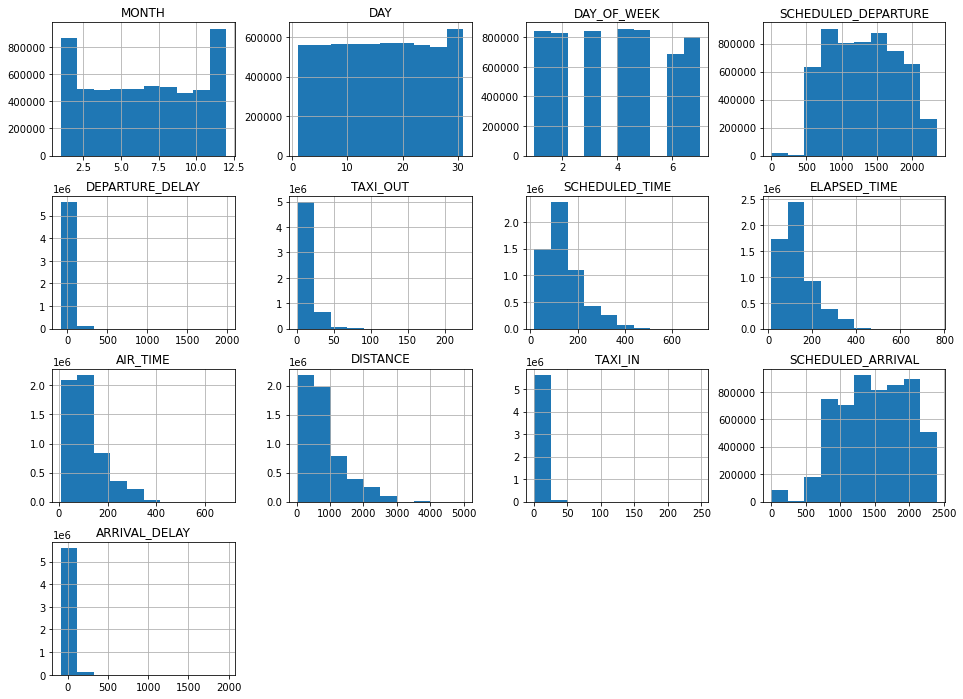

In [35]:
df.hist(figsize=(16,12))
plt.show()

In [36]:
# SCHEDULED_DEPARTURE, SCHEDULED_ARRIVAL - this columns shows hours and minutes from departures and arrivals
# I'm changing it into hours
df['SCHEDULED_DEPARTURE_H'] = df['SCHEDULED_DEPARTURE'] // 100
df['SCHEDULED_ARRIVAL_H'] = df['SCHEDULED_ARRIVAL'] // 100

In [37]:
# Deleting SCHEDULED_DEPARTURE, SCHEDULED_ARRIVAL:
df.drop(['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], axis=1, inplace=True)

In [38]:
df.sample(10)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,SCHEDULED_DEPARTURE_H,SCHEDULED_ARRIVAL_H
5270132,11,26,4,DL,BHM,ATL,0.0,11.0,61.0,42.0,27.0,134,4.0,-19.0,9,11
5260806,11,25,3,WN,DEN,SAN,1.0,11.0,140.0,154.0,139.0,853,4.0,15.0,16,17
4440705,10,4,7,DL,11697,12953,14.0,26.0,180.0,171.0,139.0,1076,6.0,5.0,15,18
425519,1,28,3,WN,SAN,LAS,4.0,8.0,80.0,56.0,41.0,258,7.0,-20.0,21,23
394979,1,26,1,HA,HNL,LAX,-6.0,10.0,325.0,304.0,288.0,2556,6.0,-27.0,22,5
5290769,11,28,6,WN,PHX,SAN,-3.0,9.0,70.0,67.0,54.0,304,4.0,-6.0,6,7
3738034,8,20,4,MQ,DFW,CID,0.0,15.0,129.0,114.0,92.0,685,7.0,-15.0,15,17
5151501,11,18,3,NK,FLL,CLE,-4.0,10.0,169.0,155.0,136.0,1062,9.0,-18.0,15,18
3090884,7,13,1,DL,MSP,DEN,35.0,15.0,125.0,118.0,96.0,680,7.0,28.0,9,10
5167408,11,19,4,EV,ATL,ROA,-2.0,22.0,83.0,76.0,51.0,357,3.0,-9.0,15,16


In [39]:
df['ORIGIN_AIRPORT'].value_counts()

ATL      343506
ORD      276554
DFW      232647
DEN      193402
LAX      192003
          ...  
13541        11
10165         9
14222         9
13502         6
11503         4
Name: ORIGIN_AIRPORT, Length: 628, dtype: int64

In [40]:
df['DESTINATION_AIRPORT'].value_counts().tail(20)

12888    50
11447    48
13964    32
ITH      31
11097    30
12016    29
10170    28
10154    27
13459    26
10581    26
12265    22
12094    20
15497    14
14025    13
13541    11
10165     9
14222     9
13502     7
11503     3
10666     1
Name: DESTINATION_AIRPORT, dtype: int64

In [41]:
# Too many unique values in columns: ORIGIN_AIRPORT, DESTINATION_AIRPORT. Deleting them also:
df.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], axis=1, inplace=True)

<AxesSubplot:>

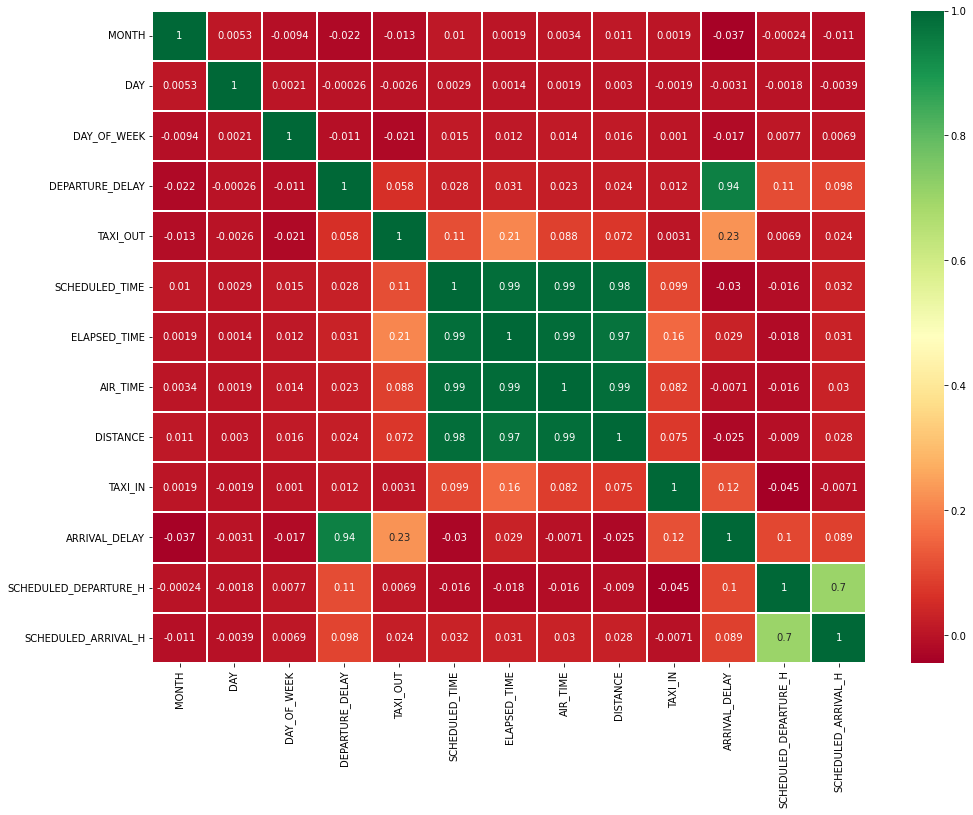

In [42]:
corr=df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.05)

### One Hot Encoding on Airline column

In [43]:
# Deleting few more columns:
df.drop(['DEPARTURE_DELAY', 'TAXI_IN', 'TAXI_OUT', 'ELAPSED_TIME', 'AIR_TIME'], axis=1, inplace=True)

In [44]:
df_ohe = pd.get_dummies(data=df, columns=['AIRLINE'])

In [45]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5714008 entries, 0 to 5819078
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   MONTH                  int64  
 1   DAY                    int64  
 2   DAY_OF_WEEK            int64  
 3   SCHEDULED_TIME         float64
 4   DISTANCE               int64  
 5   ARRIVAL_DELAY          float64
 6   SCHEDULED_DEPARTURE_H  int64  
 7   SCHEDULED_ARRIVAL_H    int64  
 8   AIRLINE_AA             uint8  
 9   AIRLINE_AS             uint8  
 10  AIRLINE_B6             uint8  
 11  AIRLINE_DL             uint8  
 12  AIRLINE_EV             uint8  
 13  AIRLINE_F9             uint8  
 14  AIRLINE_HA             uint8  
 15  AIRLINE_MQ             uint8  
 16  AIRLINE_NK             uint8  
 17  AIRLINE_OO             uint8  
 18  AIRLINE_UA             uint8  
 19  AIRLINE_US             uint8  
 20  AIRLINE_VX             uint8  
 21  AIRLINE_WN             uint8  
dtypes: float64(2), int

In [46]:
y=df_ohe.pop('ARRIVAL_DELAY')
X=df_ohe

In [47]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
# Modelling Libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Evaluation & CV Libraries
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,explained_variance_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, KFold

In [52]:
models = [ ("LGBM", LGBMRegressor(random_state=123)), 
          ('GBR', GradientBoostingRegressor(random_state=123)), ('XGB', XGBRegressor(random_state=123)) ]

results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = r2_score(y_test, model_results)
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)

In [53]:
finalResults

[('XGB', 0.08102414646247347),
 ('LGBM', 0.06734830385486212),
 ('GBR', 0.03859583185550475)]

In [50]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, SGDRegressor
models = [ ("LR", LinearRegression()), ("RDG", Ridge(random_state=123)), ("LAS", Lasso(random_state=123)),
         ("BR", BayesianRidge()), ("SGD", SGDRegressor(random_state=123))]

results = []
names = []
finalResults = []

for name,model in models:
    model.fit(X_train, y_train)
    model_results = model.predict(X_test)
    score = r2_score(y_test, model_results)
    results.append(score)
    names.append(name)
    finalResults.append((name,score))
    
finalResults.sort(key=lambda k:k[1],reverse=True)

In [51]:
finalResults

[('LR', 0.01890283556613115),
 ('RDG', 0.01890275489562654),
 ('BR', 0.0189023635100547),
 ('SGD', 0.018578096095672625),
 ('LAS', 0.01289235583538706)]

In [ ]:
xgb = XGBRegressor(random_state=123)
xgb.fit(X_train, y_train)
